# Problem Statement

Due to the recent epidemic of West Nile Virus in the Windy City, the Department of Public Health set up a surveillance and control system to help collect data on mosquito numbers, West Nile Virus appearance, and weather events.

As part of the Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we have been tasked to assess the viability of the current spray model, as well as to try and predict occurrence of West Nile Virus in Chicago by training classifier models. This will further refine the current pest management model.

<a href = 'https://www.preventivepestcontrol.com/weather-affect-mosquito-activity/'> Mosquitoes enjoy wet and warm climates and are most active in temperatures above 80 degrees</a>. Conversely, when temperatures go below 50 degrees, mosquitoes go dormant.  

Mosquito lifecycles for Culex Pipiens, the most common mosquito caught in Chicago, <a href='https://www.in.gov/health/erc/zoonotic-and-vectorborne-epidemiology-entomology/pests/culex-species-mosquitoes/'>typically range from 2-4 weeks, and even less than a week in the heat of summer</a>.

Our project will seek to:

1. Determine the effectiveness of sprays on the mosquito population
2. Predict the occcurence of West Nile Virus
3. Help provide guidelines by which to apply future sprays
4. Conduct a cost benefit analysis on the use of the pesticides in response to the epidemic

After training on the classifier models, the selection of the best model will be guided by the Precision, Recall, ROC-AUC and PR score on the validation set.

# Contents

* [Imports](#Imports)
* [Dataset](#Dataset)
* [Functions](#Functions)
* [Data Cleaning](#Data-Cleaning)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Final Train and Test Set](#Final-Train-and-Test-Set)

# Dataset

* [`train.csv`](./datasets/train.csv): Training data from the Chicago mosquito data
* [`test.csv`](./datasets/test.csv): Test data from the Chicago mosquito data
* [`weather.csv`](./datasets/weather.csv): Weather data from Chicago O'Hare and Chicago Midway weather stations for the time period
* [`spray.csv`](./datasets/spray.csv): Mosquito spray data for Chicago
* [`train_comb.csv`](./datasets/train_comb.csv): Cleaned training Data combined with the appropriate weather data from the Chicago Mosquito Data for modeling use
* [`X_train.csv`](./datasets/X_train.csv): Standardised, cleaned training data combined with the appropriate weather data from the Chicago Mosquito Data for modeling use
* [`y_train.csv`](./datasets/y_train.csv): Cleaned data West Nile Virus Presence from the Chicago Mosquito Data for modeling use

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

%matplotlib inline

In [2]:
train = pd.read_csv('./assets/train.csv')
test = pd.read_csv('./assets/test.csv')
weather = pd.read_csv('./assets/weather.csv')
spray = pd.read_csv('./assets/spray.csv')

# Functions

## Cleaning Functions

In [3]:
def adjust_columns(df):
    '''Makes column titles lowercase, and splits day, month, and year into different columns'''
    df.columns = df.columns.str.lower()
    
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

def get_duration(sun_time):
    '''Calculates day length based on sunrise and sunset'''
    hours = sun_time // 100  # hour value
    mins = sun_time % 100   # min value
    total_mins = hours * 60 + mins
    return total_mins

def impute_depart(row):
    '''Calculates the average between stations for a average temperature and imputes the missing 
    departure from norm by adding this average difference to the temperature from the other station'''
    if row['station'] == 2:
        diff = row['tavg'] - int(weather.loc[(weather['date'] == row['date']) &
                                         (weather['station'] == 1),
                                         'tavg'])
        
        row['depart'] = diff + int(weather.loc[(weather['date'] == row['date']) &
                                           (weather['station'] == 1), 
                                           'depart'])
        
    return row

def impute_tavg(row):
    '''Calculates missing average temperatures'''
    if row['tavg'] == 'M':
        row['tavg'] = round((row['tmax'] + row['tmin']) / 2) 
    return row

def check_value(df, col, station_1_idx):
    '''Checks if two consecutive rows of values are missing'''
    if ((df.loc[station_1_idx][col] in ['M','T']) & (df.loc[station_1_idx+1][col] in ['M','T'])):
        return True
    else:
        return False

def impute_data(df, col):
    '''Imputes the data of a missing value by:
    1. Calculating the average between the day before and the day after
    2. Imputes the value of a given date by adding the difference in mean of the two stations to the other station'''
    df_1 = df.loc[(df['station'] == 1) & (~df[col].str.strip().isin(['M','T'])),col].astype(float)
    df_2 = df.loc[(df['station'] == 2) & (~df[col].str.strip().isin(['M','T'])),col].astype(float)
    mean_diff = df_1.mean() - df_2.mean()
    
    idx = list(df.loc[(df[col].str.strip().isin(['M']))].index)
    
    for i in idx:
        if df.loc[i]['station'] == 1:
            if check_value(df, col, i):
                new_val = (float(df.loc[i+2][col]) + float(df.loc[i-2][col])) / 2
                df.at[i,col] = new_val
                df.at[i+1,col] = new_val
                idx.remove(i)
                idx.remove(i+1)
            else:
                df.at[i,col] = float(df.loc[i+1][col]) + mean_diff
        else:
            df.at[i,col] = float(df.loc[i-1][col]) + mean_diff
    
    zero_idx = list(df.loc[(df[col].str.strip().isin(['T']))].index)
    for i in zero_idx:
        df.at[i,col] = 0
    
    return df

## Plotting Functions

In [4]:
def plot_graphs(list_of_variables, suptitle, fig_size):
    '''This function graphs out the number of west nile virus cases seen on average for each day 
    before the weather phenomenon occurred'''
    fig, axs = plt.subplots((len(list_of_variables)//2) + 1, 2, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 18)
    fig.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 3.0, rect = [0, 0, 1, 0.95]) 
    axs = axs.ravel()
    plot_count = 0
    for variable in list_of_variables:
        temp_df = create_lag_time(variable)
        axs[plot_count].bar(
            x = temp_df.drop(columns = 'wnvpresent').columns,
            height = temp_df[temp_df['wnvpresent'] == 1].drop(columns = 'wnvpresent').sum()
        )
        axs[plot_count].set_title(f'({variable}) vs Different Lag Times', 
                  fontsize = 8)
        axs[plot_count].set_ylabel('Number of West Nile Virus Cases', fontsize = 8)
        axs[plot_count].set_xlabel(f'{variable} Lag Times', fontsize = 8)
        plot_count += 1;
        
def plot_trap_spray_wnv(train, spray):
    '''Plots sprays maps for each year along with the Traps within each spray area on a map of Chicago'''
    origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
    upperRight = [42.1, -87.5]          # lat/long of upper right corner

    mapdata = np.loadtxt("./assets/mapdata_copyright_openstreetmap_contributors.txt")

    train_2011 = train.loc[(train['year'] == 2011) & (train['wnvpresent'] == 0),:]
    train_2013 = train.loc[(train['year'] == 2013) & (train['wnvpresent'] == 0),:]
    
    train_2011_wnv = train.loc[(train['year'] == 2011) & (train['wnvpresent'] == 1),:]
    train_2013_wnv = train.loc[(train['year'] == 2013) & (train['wnvpresent'] == 1),:]
    
    spray_2011 = spray.loc[(spray['year'] == 2011),:]
    spray_2013 = spray.loc[(spray['year'] == 2013),:]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,15))
    ax[0].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
    ax[1].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
    
    ax[0].scatter(x=spray_2011['longitude'], y=spray_2011['latitude'], c='yellow', s=10, alpha = 0.2)
    ax[0].scatter(x=train_2011['longitude'], y=train_2011['latitude'], c='b', s=15, marker='s')
    ax[0].scatter(x=train_2011_wnv['longitude'], y=train_2011_wnv['latitude'], c='r', s=15, marker='+');
    ax[0].title.set_text('2011 Spray Locations vs Mosquito Traps')

    ax[1].scatter(x=spray_2013['longitude'], y=spray_2013['latitude'], c='yellow', s=10, alpha = 0.2)
    ax[1].scatter(x=train_2013['longitude'], y=train_2013['latitude'], c='b', s=15, marker='s')
    ax[1].scatter(x=train_2013_wnv['longitude'], y=train_2013_wnv['latitude'], c='r', s=15, marker='+');
    ax[1].title.set_text('2013 Spray Locations vs Mosquito Traps')
    
def spray_plot(date):
    '''Plots total number of mosquitoes caught from 1 week priod to 4 weeks post-spray 
    from the traps within a spray zone''' 
    max_lat = max(spray_clean.loc[spray_clean.index == date, 'latitude'])
    min_lat = min(spray_clean.loc[spray_clean.index == date, 'latitude'])
    max_long = max(spray_clean.loc[spray_clean.index == date, 'longitude'])
    min_long = min(spray_clean.loc[spray_clean.index == date, 'longitude'])
    
    start_date = pd.to_datetime(date) - pd.to_timedelta(7, unit='d') # start 7 days prior
    end_date = pd.to_datetime(date) + pd.to_timedelta(28, unit='d') # increase date by 28 day
    
    mask = (train_comb.index > start_date) & (train_comb.index <= end_date)
    train_tempdf = train_comb.loc[mask]
    
    weekly_mos_count = train_tempdf.loc[((train_tempdf['longitude'] <= max_long) &
                                         (train_tempdf['longitude'] >= min_long) &
                                         (train_tempdf['latitude'] <= max_lat) &
                                         (train_tempdf['latitude'] >= min_lat))
                                         ,['nummosquitos']].groupby('date').sum()
    
    spray_8 = pd.to_datetime(date) - pd.to_timedelta(8, unit='d')
    spray_10 = pd.to_datetime(date) - pd.to_timedelta(10, unit='d')
    print(f'Date Range of Day 8-10 Pre-Spray is {spray_8}, {spray_10}.')
    plt.figure(figsize=(6,4))
    plt.title(f'Number of Mosquitos Caught In Spray Zone, Sprayed: ({date})')
    plt.ylabel('Num of Mosquitos')
    plt.xlabel(f'Date Range from {start_date} & {end_date}')
    sns.barplot(
        data = weekly_mos_count,
        x = weekly_mos_count.index,
        y = 'nummosquitos',
    )
    plt.show()
    
def spray_tables(date):
    '''Prints a table indicating the number of mosquitos caught and various variables from traps 
    11 days prior to 11 days post-spray'''
    max_lat = max(spray_clean.loc[spray_clean.index == date, 'latitude'])
    min_lat = min(spray_clean.loc[spray_clean.index == date, 'latitude'])
    max_long = max(spray_clean.loc[spray_clean.index == date, 'longitude'])
    min_long = min(spray_clean.loc[spray_clean.index == date, 'longitude'])
    
    start_date = pd.to_datetime(date) - pd.to_timedelta(11, unit='d') # start 11 days prior
    end_date = pd.to_datetime(date) + pd.to_timedelta(11, unit='d') # increase date by 11 day
    
    mask = (train_comb_outer.index > start_date) & (train_comb_outer.index <= end_date)
    train_tempdf = train_comb_outer.loc[mask]
    
    train_tempdf['preciptotal'] = train_tempdf['preciptotal'].astype(float)
    train_tempdf['deg_days'] = (train_tempdf['tavg'] - 65)
    
    weekly_mos_count = train_tempdf.loc[((train_tempdf['longitude'] <= max_long) &
                                         (train_tempdf['longitude'] >= min_long) &
                                         (train_tempdf['latitude'] <= max_lat) &
                                         (train_tempdf['latitude'] >= min_lat))
                                         , 'nummosquitos'].groupby('date').sum()
    
    train_tempdf['day_of_week'] = pd.DatetimeIndex(train_tempdf.index).day_name()
    train_tempdf = train_tempdf[['day_of_week', 'ra', 'preciptotal', 'resultspeed', 
                                 'deg_days']].groupby(['date', 'day_of_week']).mean().join(weekly_mos_count)
    
    print(f'For Spray Date: {date}')
    print(train_tempdf)
    
    
    spray_8 = pd.to_datetime(date) - pd.to_timedelta(8, unit='d')
    spray_10 = pd.to_datetime(date) - pd.to_timedelta(10, unit='d')
    print(f'\nDate Range of Day 8-10 Pre-Spray is {spray_8}, {spray_10}.')
    print('\n------------------------------\n')

## EDA Functions

In [5]:
def create_lag_time(phenom):
    '''Creates a dataframe of a chosen column and time lags it 14 days vs the presence of West Nile Virus, and then
    plots the number of cases against each day.'''
    temp_df = pd.DataFrame()                           # temp dataframe to hold the lagged days
    temp_df['wnvpresent'] = train_comb['wnvpresent']
    temp_df[phenom] = train_comb[phenom]

    for n in range (1,29):                             # lag variable 14 times
        phenom_name = phenom + str(n)
        temp_df[phenom_name] = temp_df[phenom].shift(n)

    temp_df.dropna(inplace = True)                      # drop na rows from lag
    temp_df.reset_index(drop = 'first', inplace = True)
    
    return temp_df

def mos_rank(df):
    '''This function calculates the number of mosquitos that the trap catches across the dataset and assigns it an
    ordinal value in a new column [trap_rank]'''
    mos_pd = pd.DataFrame(df.groupby(['trap'])['nummosquitos'].sum())     # sum of  mosquitos for each trap
    mos_pd['trap_rank'] = mos_pd['nummosquitos']                          # trap_rank column to change
    for row in mos_pd.index:
        if mos_pd['trap_rank'][row] <= 1000:
            mos_pd['trap_rank'][row] = 1
        elif mos_pd['trap_rank'][row] <= 2000:
            mos_pd['trap_rank'][row] = 2
        elif mos_pd['trap_rank'][row] <= 3000:
            mos_pd['trap_rank'][row] = 3      
        elif mos_pd['trap_rank'][row] <= 4000:
            mos_pd['trap_rank'][row] = 4        
        else:
            mos_pd['trap_rank'][row] = 5
    mos_pd.drop(columns = 'nummosquitos', inplace = True)
    mos_dict = mos_pd.to_dict()['trap_rank']                              # dictionary of ordinal values for traps
    return mos_dict

def plot_scatter(df):
    '''Plots all the weather variables against nummosquitos in a DataFrame'''
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,18))
    fig.suptitle('Scatterplots of Weather Variables vs Number of Mosquitoes and Presence of West Nile Virus', 
                 fontsize = 16)
    plt.tight_layout()
    
    sns.scatterplot(data=df, x='depart', y='nummosquitos', hue='wnvpresent',ax=axes[0][0])
    sns.scatterplot(data=df, x='dewpoint', y='nummosquitos', hue='wnvpresent',ax=axes[0][1])
    sns.scatterplot(data=df, x='wetbulb', y='nummosquitos', hue='wnvpresent',ax=axes[1][0])
    sns.scatterplot(data=df, x='preciptotal', y='nummosquitos', hue='wnvpresent',ax=axes[1][1])
    sns.scatterplot(data=df, x='stnpressure', y='nummosquitos', hue='wnvpresent',ax=axes[2][0])
    sns.scatterplot(data=df, x='sealevel', y='nummosquitos', hue='wnvpresent',ax=axes[2][1])
    sns.scatterplot(data=df, x='resultspeed', y='nummosquitos', hue='wnvpresent',ax=axes[3][0])
    sns.scatterplot(data=df, x='resultdir', y='nummosquitos', hue='wnvpresent',ax=axes[3][1])
    sns.scatterplot(data=df, x='avgspeed', y='nummosquitos', hue='wnvpresent',ax=axes[4][0])
    plt.show()

# Data Cleaning

In [6]:
train = adjust_columns(train)
test = adjust_columns(test)
weather = adjust_columns(weather)
spray = adjust_columns(spray)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    10506 non-null  datetime64[ns]
 1   address                 10506 non-null  object        
 2   species                 10506 non-null  object        
 3   block                   10506 non-null  int64         
 4   street                  10506 non-null  object        
 5   trap                    10506 non-null  object        
 6   addressnumberandstreet  10506 non-null  object        
 7   latitude                10506 non-null  float64       
 8   longitude               10506 non-null  float64       
 9   addressaccuracy         10506 non-null  int64         
 10  nummosquitos            10506 non-null  int64         
 11  wnvpresent              10506 non-null  int64         
 12  day                     10506 non-null  int64 

In [8]:
train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,29,5,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,29,5,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,29,5,2007


In [9]:
train.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
day                       0
month                     0
year                      0
dtype: int64

In [10]:
test.isnull().sum()

id                        0
date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
day                       0
month                     0
year                      0
dtype: int64

In [11]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       2944 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   heat         2944 non-null   object        
 9   cool         2944 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        2944 non-null   object        
 14  water1       2944 non-null   object        
 15  snowfall     2944 non-null   object        
 16  precip

In [12]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14835 non-null  datetime64[ns]
 1   time       14251 non-null  object        
 2   latitude   14835 non-null  float64       
 3   longitude  14835 non-null  float64       
 4   day        14835 non-null  int64         
 5   month      14835 non-null  int64         
 6   year       14835 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 811.4+ KB


In [13]:
train['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [14]:
train['trap'].unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

## Data Cleaning for Train

In [15]:
train['month'].value_counts(normalize=True)

8     0.357034
7     0.248049
9     0.211117
6     0.149534
10    0.026271
5     0.007995
Name: month, dtype: float64

In [16]:
train['addressaccuracy'].value_counts(normalize=True)

8    0.440510
9    0.378831
5    0.171997
3    0.008662
Name: addressaccuracy, dtype: float64

In [17]:
train[train['nummosquitos'] == 50].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019 entries, 293 to 10267
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1019 non-null   datetime64[ns]
 1   address                 1019 non-null   object        
 2   species                 1019 non-null   object        
 3   block                   1019 non-null   int64         
 4   street                  1019 non-null   object        
 5   trap                    1019 non-null   object        
 6   addressnumberandstreet  1019 non-null   object        
 7   latitude                1019 non-null   float64       
 8   longitude               1019 non-null   float64       
 9   addressaccuracy         1019 non-null   int64         
 10  nummosquitos            1019 non-null   int64         
 11  wnvpresent              1019 non-null   int64         
 12  day                     1019 non-null   int64

In [18]:
train.duplicated().sum()

813

In [19]:
train.loc[train['nummosquitos'] != 50, :].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9487 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    9487 non-null   datetime64[ns]
 1   address                 9487 non-null   object        
 2   species                 9487 non-null   object        
 3   block                   9487 non-null   int64         
 4   street                  9487 non-null   object        
 5   trap                    9487 non-null   object        
 6   addressnumberandstreet  9487 non-null   object        
 7   latitude                9487 non-null   float64       
 8   longitude               9487 non-null   float64       
 9   addressaccuracy         9487 non-null   int64         
 10  nummosquitos            9487 non-null   int64         
 11  wnvpresent              9487 non-null   int64         
 12  day                     9487 non-null   int64  

In [20]:
train_clean = train.drop_duplicates(subset = ['date', 'species', 'latitude', 'longitude', 'address', 'trap', 'wnvpresent', 'nummosquitos'], keep = 'first')
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    9693 non-null   datetime64[ns]
 1   address                 9693 non-null   object        
 2   species                 9693 non-null   object        
 3   block                   9693 non-null   int64         
 4   street                  9693 non-null   object        
 5   trap                    9693 non-null   object        
 6   addressnumberandstreet  9693 non-null   object        
 7   latitude                9693 non-null   float64       
 8   longitude               9693 non-null   float64       
 9   addressaccuracy         9693 non-null   int64         
 10  nummosquitos            9693 non-null   int64         
 11  wnvpresent              9693 non-null   int64         
 12  day                     9693 non-null   int64  

Mosquito count capped at 50, additional mosquitos caught above that are made into a new record. We will group these records and sum them together to get the total number of mosquitos.

In [21]:
train_clean = train_clean.groupby(['date','address','species','block','street','trap','addressnumberandstreet','latitude','longitude','addressaccuracy','wnvpresent','day','month','year']).sum().reset_index()

In [22]:
train_clean.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,wnvpresent,day,month,year,nummosquitos
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,29,5,2007,1
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,29,5,2007,2
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,0,29,5,2007,1
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,0,29,5,2007,1
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,0,29,5,2007,1


In [23]:
train_clean.drop(columns = ['address', 'street', 'addressnumberandstreet'], inplace = True)

Since we already have latitude, longitude as exact locations, we will keep block as a general location marker and drop the following address-related columns:
* address
* street
* addressnumberandstreet

## Data Cleaning for Spray

In [24]:
spray['month'].value_counts(normalize=True)

8    0.538456
7    0.256758
9    0.204786
Name: month, dtype: float64

In [25]:
spray['longitude'].describe()

count    14835.000000
mean       -87.736690
std          0.067292
min        -88.096468
25%        -87.794225
50%        -87.727853
75%        -87.694108
max        -87.586727
Name: longitude, dtype: float64

In [26]:
train['longitude'].describe()

count    10506.000000
mean       -87.699908
std          0.096514
min        -87.930995
25%        -87.760070
50%        -87.694991
75%        -87.627796
max        -87.531635
Name: longitude, dtype: float64

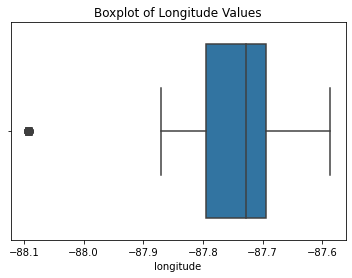

In [27]:
sns.boxplot(data=spray, x='longitude')
plt.title('Boxplot of Longitude Values');

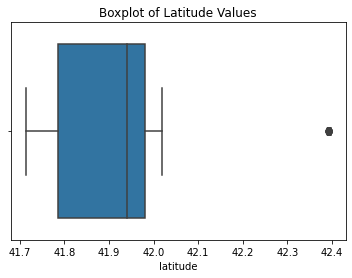

In [28]:
sns.boxplot(data=spray, x='latitude')
plt.title('Boxplot of Latitude Values');

We notice there is an outlier for longitudinal data for spray that is off the map. We will exclude these records.

In [29]:
spray_clean = spray.loc[
    (spray['longitude'] > spray['longitude'].min() + 
     (3* spray['longitude'].std())
    ) & 
    (spray['latitude'] <= spray['latitude'].max())]

In [30]:
spray_clean.describe()

,latitude,longitude,day,month,year
count,14740.000000,14740.000000,14740.000000,14740.000000,14740.000000
mean,41.901686,-87.734391,16.996947,7.947693,2012.713161
std,0.097077,0.061091,7.926638,0.679569,0.701024
min,41.713925,-87.871023,5.000000,7.000000,2011.000000
25%,41.784533,-87.794148,8.000000,7.000000,2013.000000
50%,41.939643,-87.727195,17.000000,8.000000,2013.000000
75%,41.980335,-87.693871,25.000000,8.000000,2013.000000
max,42.018907,-87.586727,29.000000,9.000000,2013.000000


In [31]:
spray_clean = spray_clean.drop_duplicates(keep = 'first')

In [32]:
spray_clean['spray'] = 1

We dropped the time column because time of day was not a concern. As long as the spray occurred, we would likely see a drop in mosquitos collected but we would also expect to see a bit of a dip 2-4 weeks later based on a smaller mosquito population reproducing.

Considerations that might change it would be if we knew when precipitation ended. However, as this is not recorded on the weather forecast, we will assume that sprays occurred post-rainfall.

In [33]:
spray_clean = spray_clean.drop(columns = 'time')

## Data Cleaning for Weather

In [34]:
weather['month'].value_counts(normalize=True)

8     0.168478
10    0.168478
5     0.168478
7     0.168478
6     0.163043
9     0.163043
Name: month, dtype: float64

In [35]:
weather['water1'].value_counts()

M    2944
Name: water1, dtype: int64

We notice all of the data in `water1` is missing. This feature will not be useful, and hence will be dropped.

In [36]:
weather = weather.drop(columns = 'water1')

In [37]:
# check for missing or trace values based on data dict
weather.isin(['T', 'M']).sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           4
heat             11
cool             11
sunrise           0
sunset            0
codesum           0
depth          1472
snowfall       1472
preciptotal       2
stnpressure       4
sealevel          9
resultspeed       0
resultdir         0
avgspeed          3
day               0
month             0
year              0
dtype: int64

### Imputing

####  Depth and Snowfall

In [38]:
weather['depth'].value_counts()

M    1472
0    1472
Name: depth, dtype: int64

In [39]:
weather['snowfall'].value_counts()

M      1472
0.0    1459
  T      12
0.1       1
Name: snowfall, dtype: int64

We will drop both depth and snowfall since most values are missing, 0 or trace.

In [40]:
weather.drop(columns = ['depth', 'snowfall'], inplace = True)

In [41]:
weather[['station','date','sunrise', 'sunset']]

,station,date,sunrise,sunset
0,1,2007-05-01,0448,1849
1,2,2007-05-01,-,-
2,1,2007-05-02,0447,1850
3,2,2007-05-02,-,-
4,1,2007-05-03,0446,1851
...,...,...,...,...
2939,2,2014-10-29,-,-
2940,1,2014-10-30,0622,1649
2941,2,2014-10-30,-,-
2942,1,2014-10-31,0623,1647


#### Sunrise and Sunset

In [42]:
# impute sunrise data with the data in the row above
for n in weather.index:
    if n % 2 == 1:
        weather['sunrise'][n] = weather['sunrise'][n-1]

<ipython-input-42-b0dc24ae8234>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['sunrise'][n] = weather['sunrise'][n-1]


In [43]:
# impute sunset data with the data in the row above
for n in weather.index:
    if n % 2 == 1:
        weather['sunset'][n] = weather['sunset'][n-1]

<ipython-input-43-d40f2b359dc5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['sunset'][n] = weather['sunset'][n-1]


In [44]:
# convert sunrise and sunset columns to numbers
weather['sunrise'] = weather['sunrise'].astype(int)
weather['sunset'] = weather['sunset'].astype(int)

In [45]:
weather['sunrise_dur'] = weather['sunrise'].apply(get_duration)
weather['sunset_dur'] = weather['sunset'].apply(get_duration)

#### Average Temperature

In [46]:
weather = weather.apply(impute_tavg, axis=1)

In [47]:
weather['tavg'] = weather['tavg'].astype(int)

#### Heat and Cool

In [48]:
for row in weather.index:
    avg_temp = weather['tavg'][row] - 65
    if avg_temp >= 0:
        weather['cool'][row] = avg_temp
        weather['heat'][row] = 0
    if avg_temp < 0:
        weather['heat'][row] = abs(avg_temp)
        weather['cool'][row] = 0        

<ipython-input-48-2eeee7d08e47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['cool'][row] = avg_temp
<ipython-input-48-2eeee7d08e47>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['heat'][row] = 0
<ipython-input-48-2eeee7d08e47>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['heat'][row] = abs(avg_temp)
<ipython-input-48-2eeee7d08e47>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

#### Departure from Norm

In [49]:
weather.loc[weather['depart'].str.contains('M')].head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year,sunrise_dur,sunset_dur
1,2,2007-05-01,84,52,68,M,51,57,0,3,448,1849,,0.00,29.18,29.82,2.7,25,9.6,1,5,2007,288,1129
3,2,2007-05-02,60,43,52,M,42,47,13,0,447,1850,BR HZ,0.00,29.44,30.08,13.3,2,13.4,2,5,2007,287,1130
5,2,2007-05-03,67,48,58,M,40,50,7,0,446,1851,HZ,0.00,29.46,30.12,12.9,6,13.2,3,5,2007,286,1131
7,2,2007-05-04,78,51,64,M,42,50,1,0,444,1852,,0.00,29.36,30.04,10.1,7,10.4,4,5,2007,284,1132
9,2,2007-05-05,66,54,60,M,39,50,5,0,443,1853,,T,29.46,30.09,11.2,7,11.5,5,5,2007,283,1133


In [50]:
weather.loc[(weather['depart'].str.contains('M')) &
            (weather['station'] == 1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year,sunrise_dur,sunset_dur


We see that all the missing values in the Depart column are found in Station 2 only.

Based on the data dictionary, Depart means the departure from normal temperature.

In order to impute the missing values here, we suggest to:
1. Take the 'tavg' difference between both stations for each day 
2. Add this difference to the Station 1's 'Depart' value to calculate Station 2's 'Depart' value

In [51]:
weather.loc[[1], 'depart']

1    M
Name: depart, dtype: object

In [52]:
weather = weather.apply(impute_depart, axis=1)

#### Wetbulb

In [53]:
weather = impute_data(weather, 'wetbulb')

#### Total Precipitation

In [54]:
weather = impute_data(weather, 'preciptotal')

#### Station Pressure

In [55]:
weather = impute_data(weather, 'stnpressure')

#### Average Speed

In [56]:
weather = impute_data(weather, 'avgspeed')

#### Sea Level

In [57]:
weather = impute_data(weather,'sealevel')

## Vectorizing Weather Phenomena

In [58]:
weather['codesum'].unique()

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer()
we_types = cvec.fit_transform(weather['codesum'])

In [60]:
we_types = pd.DataFrame(
    we_types.todense(),
    columns = cvec.get_feature_names()
            )

In [61]:
for row in range(len(we_types)):
    if we_types['tsra'][row] == 1:
        we_types['ts'][row] = 1
        we_types['ra'][row] = 1

we_types.drop(columns = 'tsra', inplace = True)

Strings of weather codes were segregated into separate columns, since weather events mostly described different phenomena. This will allow us to assess the weather events independently.

The only combined category that can be broken up seems to be TSRA, which sometimes occurs with TS and/or RA. The code will be broken up into the two categories and removed.

In [62]:
we_types.sum().sort_values(ascending = False)

ra      1035
br       813
ts       345
hz       263
dz       133
fg        43
vcts      19
fu         9
sn         6
bcfg       5
vcfg       4
mifg       3
sq         3
gr         1
dtype: int64

In [63]:
weather.shape

(2944, 24)

In [64]:
we_types.shape

(2944, 14)

In [65]:
we_types

,bcfg,br,dz,fg,fu,gr,hz,mifg,ra,sn,sq,ts,vcfg,vcts
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2940,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2941,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2942,0,0,0,0,0,0,0,0,1,1,0,0,0,0


In [66]:
weather.drop(columns = 'codesum', inplace = True)

In [67]:
weather_clean = pd.concat(
    objs = [weather, we_types],
    axis = 1
)

### Weather Averaging

For the purposes of measuring weather, we will use Station 1 (Chicago O'Hare) as the main source for weather measurements for our dataset for the following 2 reasons:
1. O'Hare is the official meteorological station of Chicago
2. Lake effect generally means that O'Hare will capture any large weather pattern from the lake as it is situated on the opposite side of the city from the shore, as opposed to Midway. As a result, O'Hare will likely have more accurate measurements, particularly in the summer, as big lake side weather patterns will that hit O'Hare will have to pass through the city.

In [68]:
weather_clean = weather_clean.loc[weather_clean['station'] == 1, :]
weather_clean.drop(columns = 'station', inplace = True)
weather_clean.reset_index()

,index,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year,sunrise_dur,sunset_dur,bcfg,br,dz,fg,fu,gr,hz,mifg,ra,sn,sq,ts,vcfg,vcts
0,0,2007-05-01,83,50,67,14,51,56,0,2,448,1849,0.00,29.10,29.82,1.7,27,9.2,1,5,2007,288,1129,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2007-05-02,59,42,51,-3,42,47,14,0,447,1850,0.00,29.38,30.09,13.0,4,13.4,2,5,2007,287,1130,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,4,2007-05-03,66,46,56,2,40,48,9,0,446,1851,0.00,29.39,30.12,11.7,7,11.9,3,5,2007,286,1131,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,2007-05-04,66,49,58,4,41,50,7,0,444,1852,0,29.31,30.05,10.4,8,10.8,4,5,2007,284,1132,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,8,2007-05-05,66,53,60,5,38,49,5,0,443,1853,0,29.40,30.10,11.7,7,12.0,5,5,2007,283,1133,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2934,2014-10-27,77,51,64,16,51,58,1,0,618,1653,0.00,28.92,29.66,12.0,19,12.9,27,10,2014,378,1013,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1468,2936,2014-10-28,68,45,57,10,38,47,8,0,619,1651,0,29.15,29.85,14.8,26,15.6,28,10,2014,379,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1469,2938,2014-10-29,49,36,43,-4,32,40,22,0,620,1650,0.00,29.36,30.06,9.5,29,9.9,29,10,2014,380,1010,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1470,2940,2014-10-30,51,32,42,-4,34,40,23,0,622,1649,0.00,29.34,30.09,5.1,24,5.5,30,10,2014,382,1009,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Numericizing Columns

In [69]:
num_list = ['depart', 'wetbulb', 'preciptotal', 'stnpressure', 'sealevel', 'avgspeed']
for col in num_list:
    weather_clean[col] = weather_clean[col].map(lambda x: float(x))

## Combine Train and Weather, Spray and Weather

In [70]:
train_comb = train_clean.merge(
    weather_clean, 
    how = 'left', 
    on = ['date', 'day', 'month', 'year'])

In [71]:
train_comb_outer = train_clean.merge(
    weather_clean, 
    how = 'left', 
    on = ['date', 'day', 'month', 'year'])

In [72]:
train_comb = train_comb.set_index('date').sort_index()
spray_clean = spray_clean.set_index('date').sort_index()
train_comb_outer = train_comb_outer.set_index('date').sort_index()

# Exploratory Data Analysis

## Presence of West Nile Virus in Mosquito Species

### Frequency of mosquitoes over the years (by species)

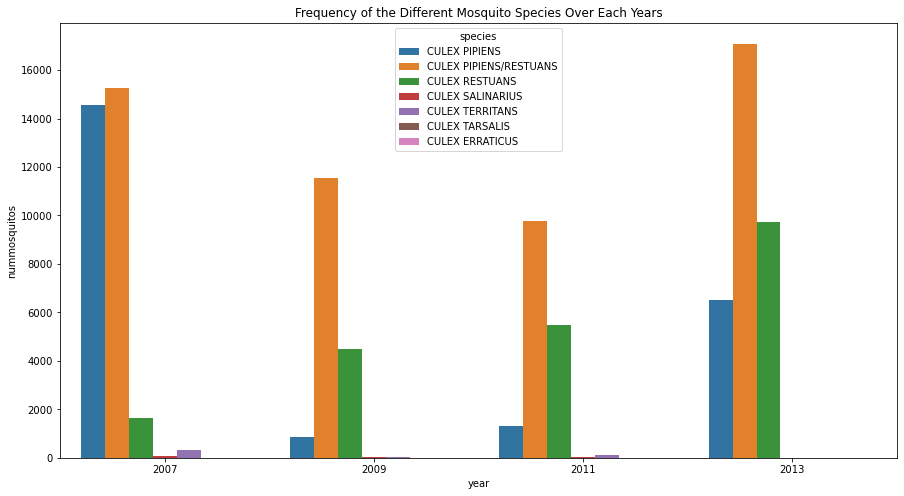

In [73]:
plt.figure(figsize = (15,8))
sns.barplot(data = train_comb.groupby(['year', 'species'])['nummosquitos'].sum().reset_index(),
            x = 'year',
            y = 'nummosquitos',
            hue = 'species')
plt.title('Frequency of the Different Mosquito Species Over Each Years');

### Likelihood of Presence of West Nile Virus by Species

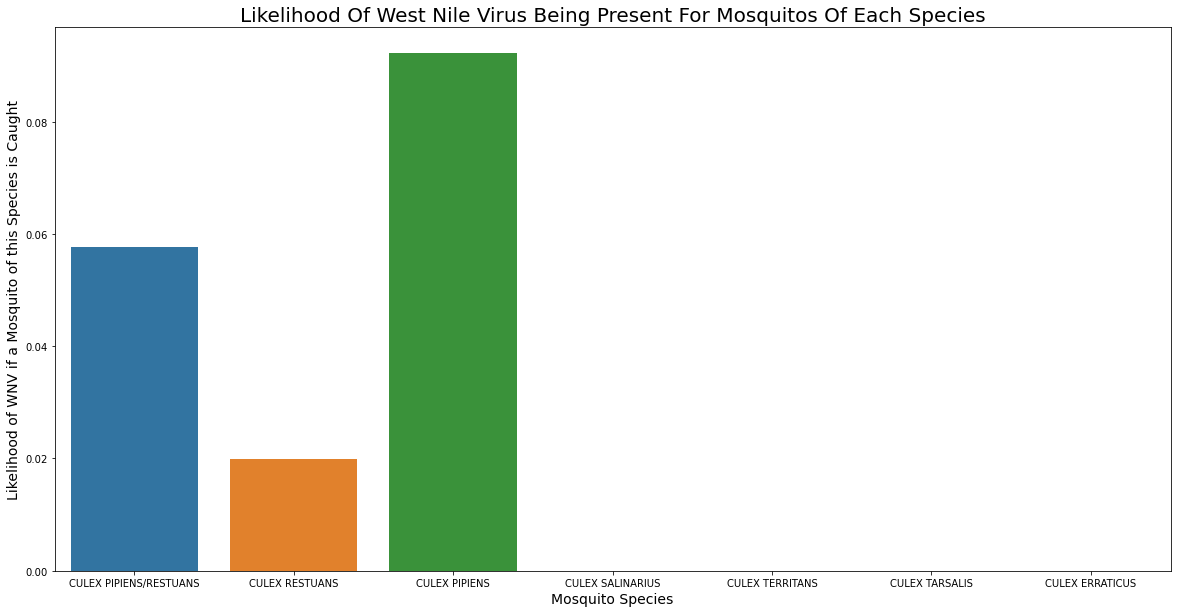

In [74]:
mos_prob = {}
mos_species = [name for name in train_comb['species'].unique()]
for mos in mos_species:
    prob = train_comb.loc[train_comb['species'] == mos, 'wnvpresent'].value_counts(normalize = True)[0]
    if prob == 1:
        mos_prob[mos] = 0
    else:
        mos_prob[mos] = (1 - prob)
        
mos_prob = pd.DataFrame(
    mos_prob.items(),
    columns = ['species', 'prob']
)

plt.figure(figsize=(20,10))
plt.title('Likelihood Of West Nile Virus Being Present For Mosquitos Of Each Species', fontsize = 20)
sns.barplot(
    data = mos_prob,
    x = 'species',
    y = 'prob'
)
plt.ylabel('Likelihood of WNV if a Mosquito of this Species is Caught', fontsize = 14)
plt.xlabel('Mosquito Species', fontsize = 14);

### Mosquito Transmission of West Nile Virus

Only Culex Pipiens and Culex Restuans are associated with positive west nile virus cases. For the purposes of this model, we will drop the other breeds of mosquitos as there are no positive cases to train the model upon.

In [75]:
train_comb = train_comb.loc[(train_comb['species'] == 'CULEX PIPIENS')|
                            (train_comb['species'] == 'CULEX PIPIENS/RESTUANS')|
                            (train_comb['species'] == 'CULEX RESTUANS')
                            , :]

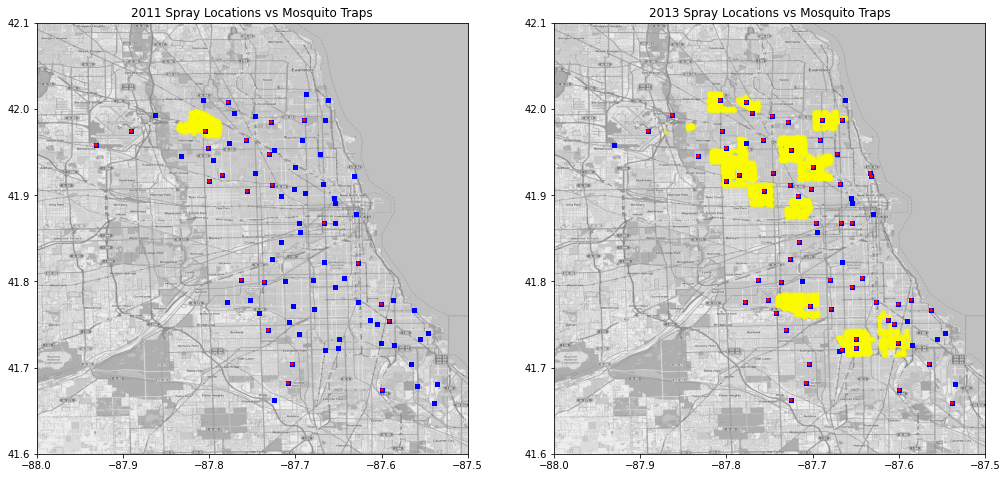

In [76]:
plot_trap_spray_wnv(train_clean, spray_clean)

## Spray Data Analysis

### Spray Dates & Effectiveness

Date Range of Day 8-10 Pre-Spray is 2011-08-30 00:00:00, 2011-08-28 00:00:00.


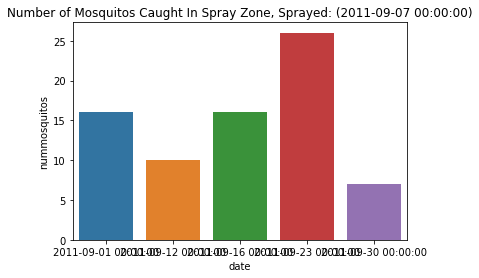

Date Range of Day 8-10 Pre-Spray is 2013-07-09 00:00:00, 2013-07-07 00:00:00.


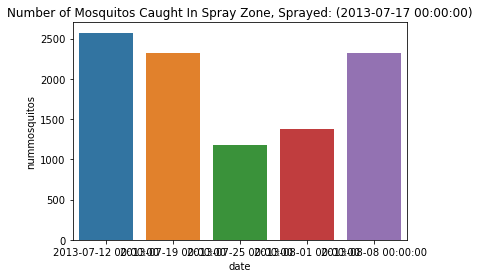

Date Range of Day 8-10 Pre-Spray is 2013-07-17 00:00:00, 2013-07-15 00:00:00.


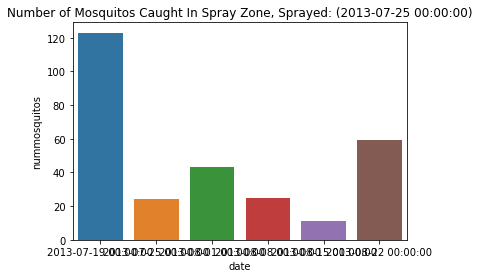

Date Range of Day 8-10 Pre-Spray is 2013-07-31 00:00:00, 2013-07-29 00:00:00.


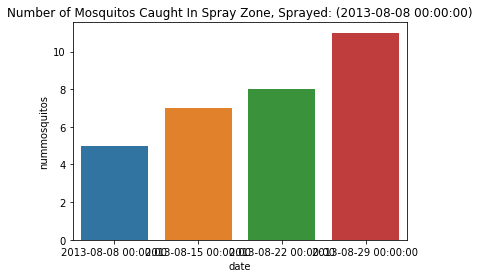

Date Range of Day 8-10 Pre-Spray is 2013-08-07 00:00:00, 2013-08-05 00:00:00.


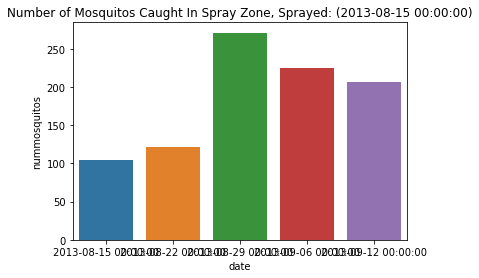

Date Range of Day 8-10 Pre-Spray is 2013-08-08 00:00:00, 2013-08-06 00:00:00.


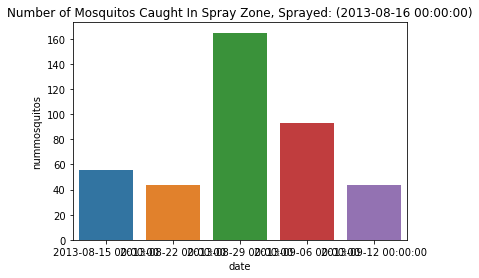

Date Range of Day 8-10 Pre-Spray is 2013-08-14 00:00:00, 2013-08-12 00:00:00.


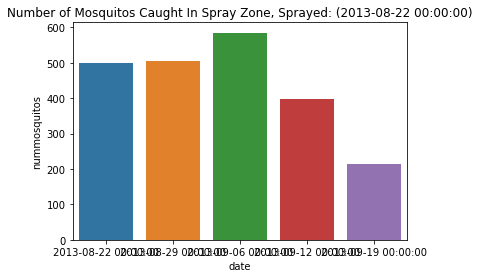

Date Range of Day 8-10 Pre-Spray is 2013-08-21 00:00:00, 2013-08-19 00:00:00.


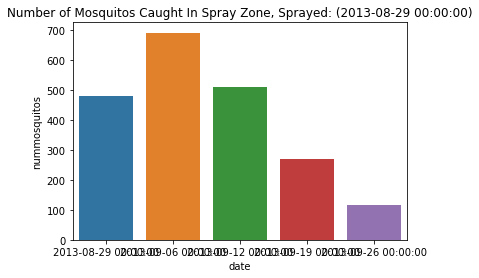

Date Range of Day 8-10 Pre-Spray is 2013-08-28 00:00:00, 2013-08-26 00:00:00.


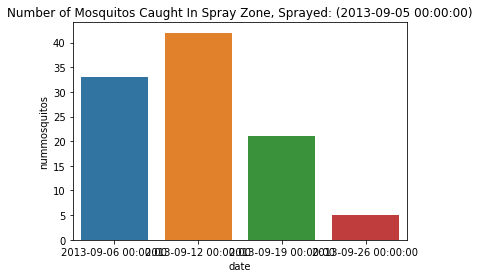

In [77]:
for date in spray_clean.index.unique():
    spray_plot(date)

In [78]:
for date in spray_clean.index.unique():
    spray_tables(date)

For Spray Date: 2011-09-07 00:00:00
                        ra  preciptotal  resultspeed  deg_days  nummosquitos
date       day_of_week                                                      
2011-09-01 Thursday      0          0.0          5.2        17          16.0
2011-09-02 Friday        0          0.0          4.9        19           NaN
2011-09-12 Monday        0          0.0         10.5        10          10.0
2011-09-16 Friday        0          0.0          1.4       -13          16.0

Date Range of Day 8-10 Pre-Spray is 2011-08-30 00:00:00, 2011-08-28 00:00:00.

------------------------------

For Spray Date: 2013-07-17 00:00:00
                        ra  preciptotal  resultspeed  deg_days  nummosquitos
date       day_of_week                                                      
2013-07-08 Monday        1         0.50          7.8        13           975
2013-07-12 Friday        0         0.00          4.0         6          2572
2013-07-19 Friday        0         0.58       

<ipython-input-4-149402bd0583>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tempdf['preciptotal'] = train_tempdf['preciptotal'].astype(float)
<ipython-input-4-149402bd0583>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tempdf['deg_days'] = (train_tempdf['tavg'] - 65)
<ipython-input-4-149402bd0583>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

As previously stated, mosquito life cycle for Culex Pipiens can take anywhere from 1 week to 4. For this reason, data was compared for 28 days after sprays to the last collection 7 days prior.

According to the WHO, <a href='https://www.who.int/westernpacific/about/how-we-work/pacific-support/news/detail/05-05-2014-mosquito-fogging-will-not-harm-you-reminds-who-and-solomon-islands-ministry-of-health'>spray effectiveness only lasts the day it is sprayed</a>. Therefore, if effects of the spray can only be analysed if it is applied Monday to Wednesday, following which, results would be seen in the number of mosquitos caught when recorded during the rest of the week.

In an examination of the spray effectiveness between the two dates, we see that mosquito populations post-sprays did not often react predictably in a comparison pre-spraying and post-spraying. As the sprays do occur during a similar time window, we can expect that the warmth of the time period would be similar and there would be a smaller variation in the life cycle of the mosquito. Therefore, we will make the assumption that a meaningful impact of spray application would occue in a similar week. 

Furthermore, we can see that on a number of days sprayed, a strong wind can be seen, which can lead to pesticide drift and removal of the pesticide fog from the desired location.

When examining the data, we do not see any similar correlation in mosquito population change post-spray. As a result, we will be dropping the spray data from our dataset.

## Weather Data Analysis

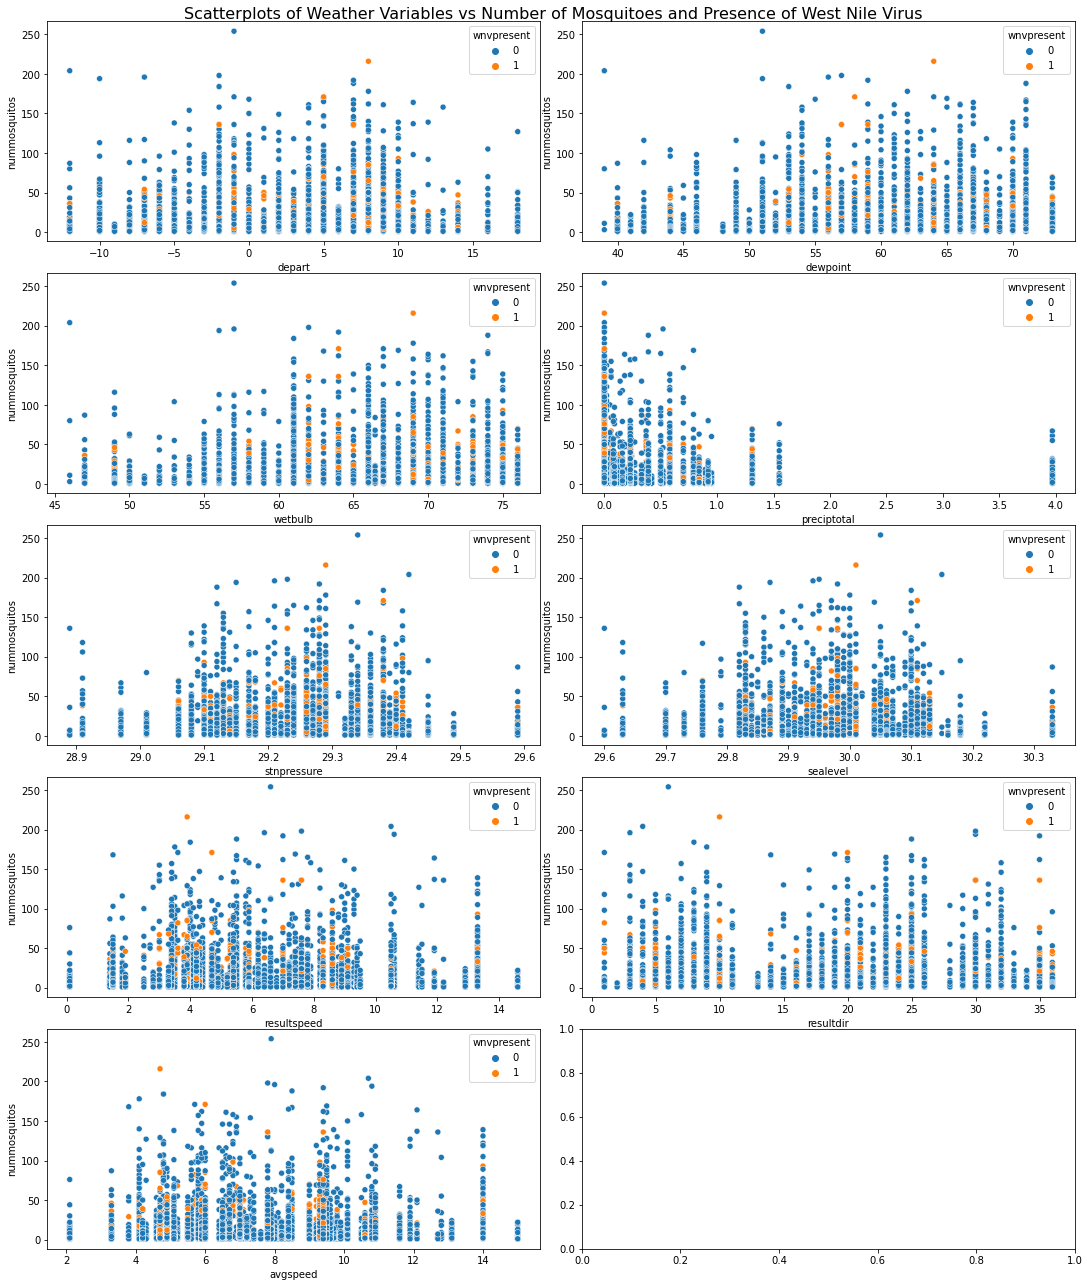

In [79]:
plot_scatter(train_comb)

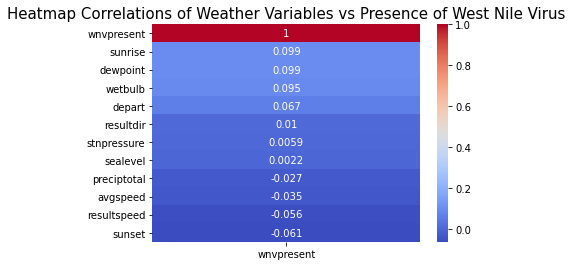

In [80]:
weather_corr = train_comb[['depart',
       'dewpoint', 'wetbulb', 'sunrise', 'sunset', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed','wnvpresent']].corr()
sns.heatmap(weather_corr[['wnvpresent']].sort_values(by='wnvpresent', ascending=False),  annot=True, cmap='coolwarm',)
plt.title('Heatmap Correlations of Weather Variables vs Presence of West Nile Virus', fontsize = 15);

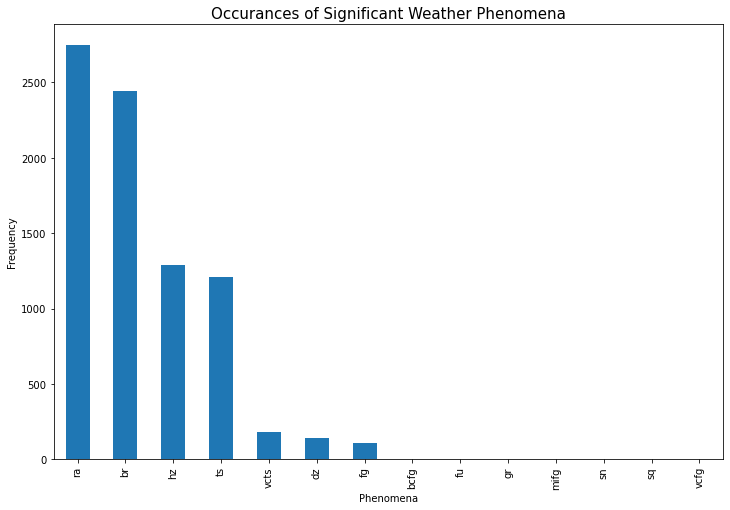

In [81]:
weather_phenom = [x for x in we_types.columns]
plt.figure(figsize = (12,8))
plt.title('Occurances of Significant Weather Phenomena', fontsize = 15)
plt.xlabel('Phenomena')
plt.ylabel('Frequency')
train_comb.loc[:, weather_phenom].sum().sort_values(ascending = False).plot.bar();

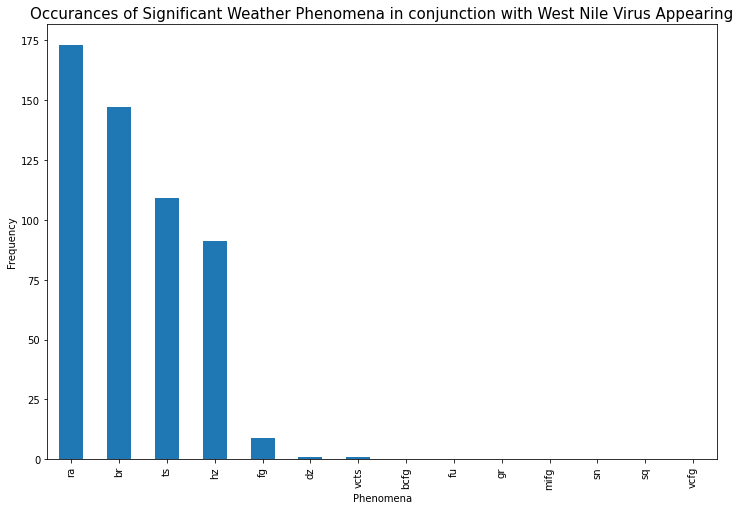

In [82]:
plt.figure(figsize = (12,8))
plt.title('Occurances of Significant Weather Phenomena in conjunction with West Nile Virus Appearing', fontsize = 15)
plt.xlabel('Phenomena')
plt.ylabel('Frequency')
train_comb.loc[train_comb['wnvpresent'] == 1, weather_phenom].sum().sort_values(ascending = False).plot.bar();

In [83]:
weather_to_drop = [x for x in train_comb[weather_phenom].columns if train_comb[x].sum() == 0]
print(weather_to_drop)

['bcfg', 'fu', 'gr', 'mifg', 'sn', 'sq', 'vcfg']


Because the following weather features neither display any predictive ability nor do they appear often, we will drop them from the train set:
* bcfg
* fu
* gr
* mifg
* sn
* sq
* vcfg

## Correlation Matrix

In [84]:
train_comb['total_sunlight_mins'] = train_comb['sunset_dur'] - train_comb['sunrise_dur']

In [85]:
train_comb.drop(columns=['sunrise_dur', 'sunset_dur'], inplace=True)

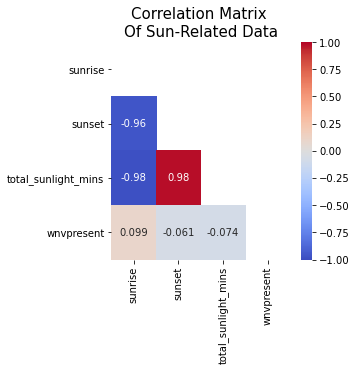

In [86]:
sun_data = train_comb[['sunrise', 'sunset', 'total_sunlight_mins', 'wnvpresent']].corr()
plt.figure(figsize = (4,4))
mask = np.zeros_like(sun_data)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(sun_data, mask = mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix \nOf Sun-Related Data', size = 15);

## Temperature Data

In [87]:
train_comb['deg_days'] = (train_comb['tavg'] - 65)

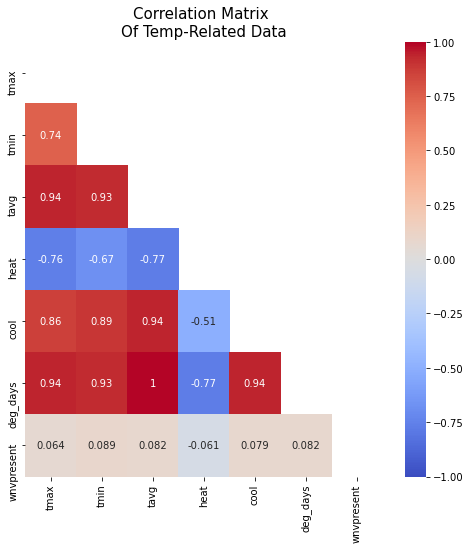

In [88]:
temp_data = train_comb[['tmax', 'tmin', 'tavg', 'heat', 'cool', 'deg_days', 'wnvpresent']].corr()
plt.figure(figsize = (8,8))
mask = np.zeros_like(temp_data)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(temp_data, mask = mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix \nOf Temp-Related Data', size = 15);

In [89]:
train_comb.drop(columns = ['heat', 'cool'], inplace = True)

None of the temperature data seems to correlate very well with the presence of wnv virus and it will be likely that temperature will correlate with specific times of the year, which will be covered by by time of the year.

Instead to cover both the heat and the cool, we will use a engineered feature called deg_days that will cover the breadth of both these features.

In [90]:
train_comb.groupby(['wnvpresent', 'deg_days'])['nummosquitos'].mean().sort_values(ascending = False)

wnvpresent  deg_days
1            5          51.333333
             15         39.291667
             14         33.533333
             19         33.117647
             7          32.025974
                          ...    
0           -14          3.519231
            -15          3.442623
            -7           3.339286
             1           2.983193
            -9           2.116667
Name: nummosquitos, Length: 53, dtype: float64

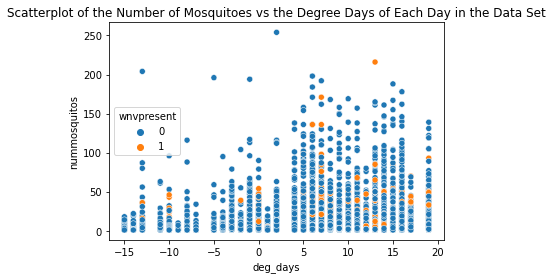

In [91]:
sns.scatterplot(data=train_comb, x='deg_days', y='nummosquitos', hue='wnvpresent')
plt.title('Scatterplot of the Number of Mosquitoes vs the Degree Days of Each Day in the Data Set');

In [92]:
train_comb.loc[train_comb['wnvpresent'] == 1, weather_phenom].sum().sort_values(ascending = False)

ra      173
br      147
ts      109
hz       91
fg        9
dz        1
vcts      1
bcfg      0
fu        0
gr        0
mifg      0
sn        0
sq        0
vcfg      0
dtype: int64

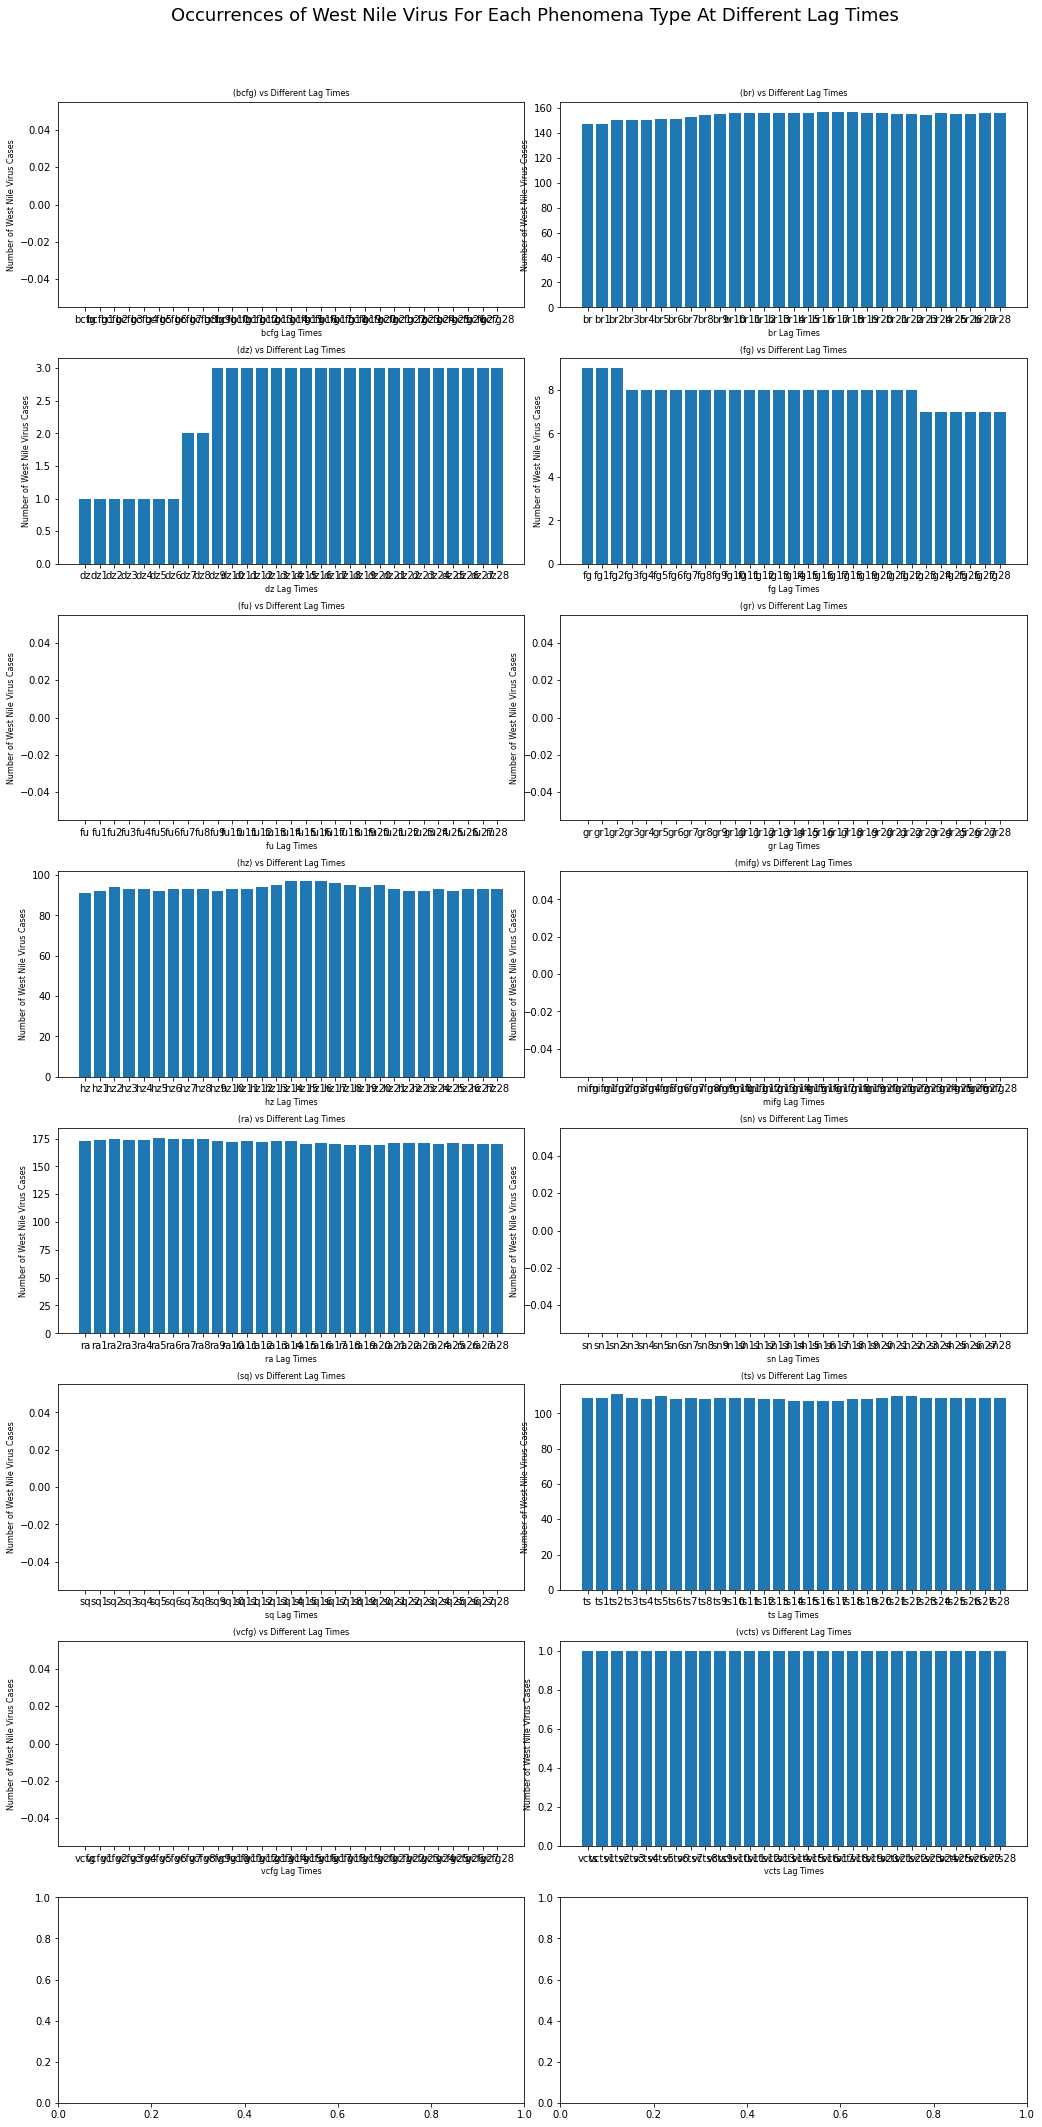

In [93]:
plot_title = 'Occurrences of West Nile Virus For Each Phenomena Type At Different Lag Times'
fig_size = (14, 30)
plot_graphs(weather_phenom, plot_title, fig_size)

In [94]:
train_comb['br10'] = train_comb['br'].shift(10)
train_comb['dz10'] = train_comb['dz'].shift(10)
train_comb['br10'] = train_comb['br10'].fillna(0)
train_comb['dz10'] = train_comb['dz10'].fillna(0)

When we extend the timeline to examine the influence of weather on the appearance of mosquitos later, we note that br (mist) and dz (drizzle) do consistently show a rise in the number of cases that occur 10 days after the event. 

Mosquitos do use stagnant water sources as breeding grounds, it is possible that the occurrences of these events are more likely associated with times when water is more likely to stay, possibly due to cool weather, or being overlooked as less of a rain event than a heavy downpour.

We will engineer a feature for the 10th day after a br or dz event to test it for predictive power.

In [95]:
train_comb.drop(columns = ['longitude', 'latitude'], inplace = True)

## Date Time Measurement

It is like that time measurements will have a high statistical correlation with our measurements, as mosquitos are much more active in the summer, with warmer and longer days.

As days count days each month and years do not sort out seasonality, these two measurements and date will be discarded for their lack of correlation. Months will be kept and One Hot Encoded.

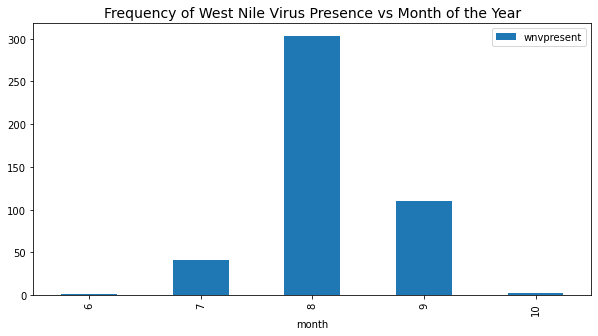

In [96]:
train_comb.loc[train_comb['wnvpresent'] == 1, ['wnvpresent', 'month']].groupby('month').count().plot(
    kind = 'bar', figsize = (10,5)
)
plt.title('Frequency of West Nile Virus Presence vs Month of the Year', fontsize = 14);

In [97]:
train_comb.drop(columns = ['day', 'year'], inplace = True)

## Location Markers

In [98]:
train.loc[train['addressaccuracy'] == 3, 'street'].value_counts()

 N ASHLAND AVE OVERPASS    91
Name: street, dtype: int64

A low address accuracy seems to correlate with a location that is not an exact address, with many of the locations being a highway.

This will be dropped, since we already have block, and latitude and longitude.

In [99]:
train_comb.loc[
    train_comb[
        'wnvpresent'
    ] == 1,
    ['wnvpresent', 'block'
    ]].groupby(
    'block'
).count(
).sort_values(
    'wnvpresent',
    ascending = False
).head()

,wnvpresent
block,
10,65
22,26
11,24
58,20
42,16


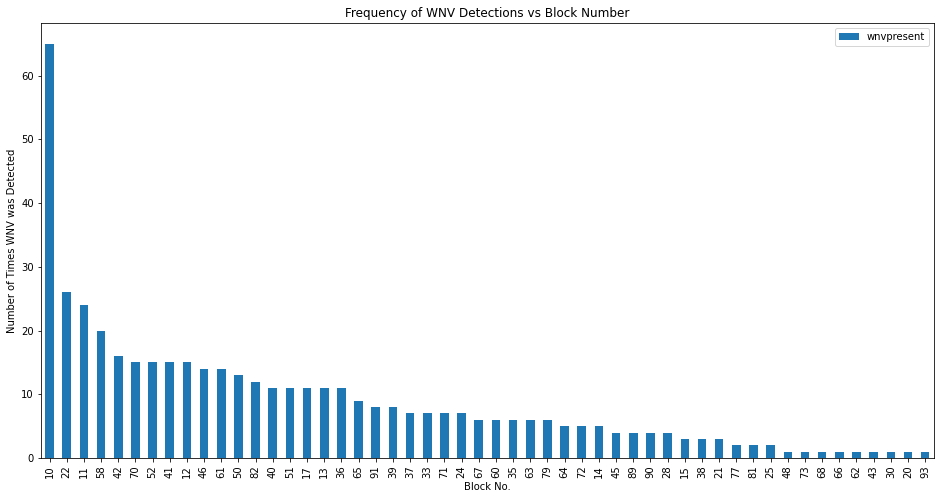

In [100]:
# graph blocks vs wnv
train_comb.loc[
    train_comb[
        'wnvpresent'
    ] == 1,
    ['wnvpresent', 'block'
    ]].groupby(
    'block'
).count(
).sort_values(
    'wnvpresent',
    ascending = False
).plot(
    kind = 'bar', 
    figsize = (16,8)
)

plt.title('Frequency of WNV Detections vs Block Number')
plt.xlabel('Block No.')
plt.ylabel('Number of Times WNV was Detected');

## Feature Engineering

### Mosquito Species Ordinal

In [101]:
train_comb['species_rank'] = train_comb['species'].map({
    'CULEX PIPIENS' : 1,
    'CULEX PIPIENS/RESTUANS' : 2,
    'CULEX RESTUANS': 3
})
train_comb.drop(columns = 'species', inplace = True)

Species were ordinalised based on the probability of West Nile Virus being present when they were found

### Mosquito Trap Rank

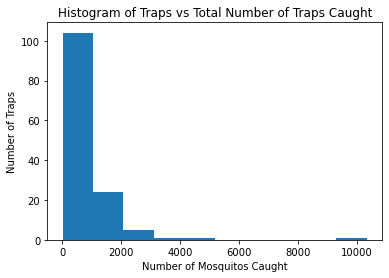

In [102]:
train_comb.groupby(['trap'])['nummosquitos'].sum().sort_values(ascending = False).plot(kind = 'hist')
plt.title('Histogram of Traps vs Total Number of Traps Caught')
plt.ylabel('Number of Traps')
plt.xlabel('Number of Mosquitos Caught');

In [103]:
train_comb.groupby('trap')['nummosquitos'].sum().sort_values(ascending = False)

trap
T900    10336
T115     5152
T138     3306
T002     2892
T135     2544
        ...  
T237       18
T072       17
T078       17
T149       14
T040        6
Name: nummosquitos, Length: 136, dtype: int64

In [104]:
mos_dict = mos_rank(train_comb)
train_comb['trap_rank'] = train_comb['trap'].map(mos_dict)

In an examination of the average number of mosquitos for each trap, we can see that there are clearly groups of traps that typically capture more mosquitos than others. As a results, we will rank the mosquitos in buckets of 1000s, with traps that have caught more than 4000 in the highest tier.

# Final Train and Test Set

Here, we generate our datasets for running our models in Part 2, and also prepare the train and test data for submission to Kaggle after finding the optimal model.

In [105]:
list_to_drop = ['addressaccuracy', 'tmin', 'tmax', 'tavg', 'total_sunlight_mins', 'sunrise', 
                'sunset', 'nummosquitos', 'trap']

In [106]:
train_comb.drop(columns = list_to_drop, inplace = True)
train_comb.drop(columns = weather_to_drop, inplace = True)
train_comb[['trap_rank', 'species_rank']] = train_comb[['trap_rank', 'species_rank']].astype(float)

In [107]:
test_final = test.merge(       # Merge with weather
    weather_clean, 
    how='left', 
    on = ['date', 'day', 'month', 'year'])

test_final = test_final.set_index('date').sort_index()       # set date as index

test_final['species_rank'] = test_final['species'].map({     # Assigning Mosquito Ranks
    'CULEX PIPIENS' : 1,
    'CULEX PIPIENS/RESTUANS' : 2,
    'CULEX RESTUANS': 3
})

test_final['trap_rank'] = test_final['trap'].map(mos_dict)   # Add trap_rank
test_final['deg_days'] = (test_final['tavg'] - 65)           # Add deg_days
test_final['br10'] = test_final['br'].shift(10)
test_final['dz10'] = test_final['dz'].shift(10)

test_final['species_rank'] = test_final['species_rank'].fillna(0) # Accounting for 
test_final['trap_rank'] = test_final['trap_rank'].fillna(0)     # unseen variables
test_final['br10'] = test_final['br10'].fillna(0) 
test_final['dz10'] = test_final['dz10'].fillna(0) 

test_drop = ['address', 'street', 'addressaccuracy', 'addressnumberandstreet', 'heat', 'cool', 
             'longitude', 'latitude', 'day', 'year', 'species', 'tavg', 'tmin', 'tmax', 'sunrise', 
             'sunset', 'sunrise_dur', 'sunset_dur', 'trap']

test_final.drop(columns = test_drop, inplace = True)         # Drop unused variables
test_final.drop(columns = weather_to_drop, inplace = True)   # Drop unused weather conditions
test_final.reset_index(inplace = True)
test_final.drop(columns = 'date', inplace = True)
test_no_id = test_final.drop(columns = 'id')              # Drop id column before 

In [108]:
train_comb.to_csv('assets/train_comb.csv')
X_train = train_comb.drop(columns = 'wnvpresent')
y_train = train_comb['wnvpresent'].reset_index().drop(columns = 'date')

In [109]:
num_list = ['depart', 'dewpoint', 'wetbulb', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 
            'resultdir', 'avgspeed', 'deg_days', 'species_rank', 'trap_rank']
weather_cats = ['br', 'dz', 'fg', 'hz', 'ra', 'ts', 'vcts', 'br10', 'dz10']
cat_list = ['block', 'month']

In [110]:
test_no_id['block'] = test_no_id['block'].apply(lambda x: 0 if x == 26 else x)

sc = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

X_train_num = sc.fit_transform(X_train[num_list])
test_no_id_num = sc.transform(test_no_id[num_list])

X_train_cat = ohe.fit_transform(X_train[cat_list])
test_no_id_cat = ohe.transform(test_no_id[cat_list])

In [111]:
X_train_final = pd.concat(objs = [
    pd.DataFrame(                                      # Standardised variables
            columns = X_train[num_list].columns,
            data = X_train_num
    ),
    pd.DataFrame(
        X_train_cat, 
        columns = ohe.get_feature_names(cat_list)
    ),
    X_train[weather_cats].reset_index()
], axis = 1).drop(columns = 'date')

In [112]:
test_final = pd.concat(objs = [
    pd.DataFrame(                                      # Standardised variables
        columns = test_no_id[num_list].columns,
        data = test_no_id_num
    ),
    pd.DataFrame(
        test_no_id_cat, 
        columns = ohe.get_feature_names(cat_list)
    ),
    test_no_id[weather_cats].reset_index(),
    test_final['id']
],axis = 1)

In [113]:
X_train_final.to_csv('assets/X_train.csv')
y_train.to_csv('assets/y_train.csv')
test_final.to_csv('assets/test_final.csv')